In [1]:
!pip install tensorflow-gpu==1.14.0



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.14.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==1.14.0


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

In [ ]:
np.random.seed(1170)#200
tf.set_random_seed(1170)#200

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.x = X
        self.u = u
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        
        # Initialize parameters
        self.lambda_1 = tf.to_float(1)
        self.lambda_2 = tf.to_float(0.5)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf)
        self.f_pred = self.net_f(self.x_tf)
        
        self.loss,self.t = self.lossf(self.x_tf,self.u_tf)
        self.derf = self.der(self.x_tf,self.u_tf)

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss , 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0* np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=1)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
    def p(self,tt):
        print(list(tt))
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            #W=tf.Variable(tf.zeros([layers[l], layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) 
        H = 2.0*(X- self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-1):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H,W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H,W), b)
        return Y

    def net_u(self, x):  
        u = self.neural_net(x, self.weights, self.biases)
        return u


    def net_f(self, x):
        lambda_1 = self.lambda_1        
        lambda_2 = self.lambda_2
        u = self.net_u(x)
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_xxx = tf.gradients(u_xx, x)[0]
        f = lambda_1*u_xxx + lambda_2*u*u_xx 
        return f
    
    def net_theta(self,x):
        lambda_1 = self.lambda_1        
        lambda_2 = self.lambda_2
        u = self.net_u(x)

    def lossf(self, x, u):
        f_cap = self.net_f(x)
        u_cap = self.net_u(x)
        u_x = tf.gradients(u_cap, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        loss_f = tf.reduce_mean(tf.square(f_cap)+tf.square(u_cap[0])+tf.square(u_x[0])+tf.square(u_x[-1]-1) )
        return loss_f,u_xx[0]

    def der(self, x, u):
        f_cap = self.net_f(x)
        u_cap = self.net_u(x)
        u_x = tf.gradients(u_cap, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        return u_x, u_xx

    
    def callback(self, loss,t):
        T.append(float(t))
        print('Loss: %e , u_xx0 : %f' % (loss,t))
    
    def train(self, nIter):
          tf_dict = {self.x_tf: self.x}
          start_time = time.time()
          for it in range(nIter):
              self.sess.run(self.train_op_Adam, tf_dict)
              # Print
              if it % 10 == 0:
                  elapsed = time.time() - start_time
                  loss_value = self.sess.run(self.loss, tf_dict)
                  t_value=self.sess.run(self.t)
                  print('It: %d, Loss: %.3e, Time: %.5f' % (it, loss_value,t_value, elapsed))
                  start_time = time.time()
          self.optimizer.minimize(self.sess,
                                  feed_dict = tf_dict,
                                  fetches = [self.loss,self.t],
                                  loss_callback = self.callback)
          
          
    def predict(self, X_star):
        tf_dict = {self.x_tf: X_star}
        u_sta = self.sess.run(self.u_pred, tf_dict)
        f_sta = self.sess.run(self.f_pred, tf_dict)
        return u_sta, f_sta
    
    def derivatives(self, X_star, u_star):
       tf_dict = {self.x_tf: X_star, self.u_tf: u_star}
       ud = self.sess.run(self.derf,tf_dict)
       return ud 

if __name__ == "__main__": 
     

    N_u =80
    layers = [1,100,100,100,1]
    
    data = pd.read_csv('Blasius_30_10000.csv')
    #data = pd.read_csv('Blasiusdata.csv')

    X = data['eta']
    Exact = np.real(data['f']).T
    T=[]
    
    X_star = np.array(X)[:,None]
    u_star = Exact[:,None]          

    # Doman bounds
    lb = tf.to_float(0)              ######taken from given eta
    ub = tf.to_float(30)  
  
    ######################################################################
    ######################## Noiseles Data ###############################
    ######################################################################
    noise = 0.0            
             
    idx = np.append(np.array([0]),np.random.choice(X_star.shape[0], N_u-1, replace=False))
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]
    
    model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
    model.train(0)
    
    u_pred, f_pred = model.predict(X_star)
    print("u predicted:",u_pred)
    print("f predicted:",f_pred)
    
    u_x, u_xx = model.derivatives(X_star, u_star)   
    print("first derivative:",u_x)
    print("second derivative:",u_xx)

    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    
    print('Error u: %e' % (error_u)) 
    print(T)

Loss: 1.017243e+00 , u_xx0 : -0.000067
Loss: 7.700510e+00 , u_xx0 : 0.002347
Loss: 1.001560e+00 , u_xx0 : -0.000005
Loss: 9.992790e-01 , u_xx0 : 0.000009
Loss: 9.908536e-01 , u_xx0 : 0.000067
Loss: 8.994936e-01 , u_xx0 : 0.000932
Loss: 8.144836e-01 , u_xx0 : 0.003002
Loss: 8.117031e-01 , u_xx0 : 0.001925
Loss: 1.174641e+00 , u_xx0 : 0.003524
Loss: 7.951505e-01 , u_xx0 : 0.002305
Loss: 7.904007e-01 , u_xx0 : 0.002785
Loss: 7.846091e-01 , u_xx0 : 0.003368
Loss: 7.803325e-01 , u_xx0 : 0.003755
Loss: 7.660671e-01 , u_xx0 : 0.004517
Loss: 7.349530e-01 , u_xx0 : 0.005285
Loss: 6.778938e-01 , u_xx0 : 0.005276
Loss: 6.010050e-01 , u_xx0 : 0.005238
Loss: 5.973634e-01 , u_xx0 : 0.005913
Loss: 5.920483e-01 , u_xx0 : 0.005586
Loss: 5.650203e-01 , u_xx0 : 0.006082
Loss: 5.366012e-01 , u_xx0 : 0.007101
Loss: 3.705024e+00 , u_xx0 : 0.003742
Loss: 5.313108e-01 , u_xx0 : 0.007259
Loss: 5.655376e-01 , u_xx0 : 0.006506
Loss: 5.173313e-01 , u_xx0 : 0.007579
Loss: 5.056445e-01 , u_xx0 : 0.007959
Loss: 4.98

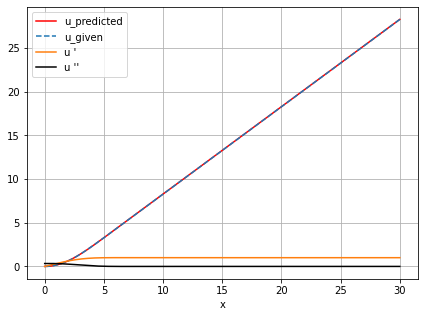

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(X_star,u_pred,label="u_predicted",color="red")
plt.plot(X_star,u_star,linestyle="dashed",label="u_given")
plt.plot(X_star,u_x,label="u '")
plt.plot(X_star,u_xx,label="u ''",color="black")
plt.xlabel("x")
plt.legend()
plt.grid()

#plt.savefig("lr:0.95.png")


In [ ]:
data = pd.read_csv('Blasius_30_10000.csv')
fir_der=data['f_t']
print(fir_der)

0       0.000000
1       0.000996
2       0.001992
3       0.002988
4       0.003984
          ...   
9995    0.999885
9996    0.999885
9997    0.999885
9998    0.999885
9999    0.999885
Name: f_t, Length: 10000, dtype: float64


In [ ]:

second_der=data['f_tt']

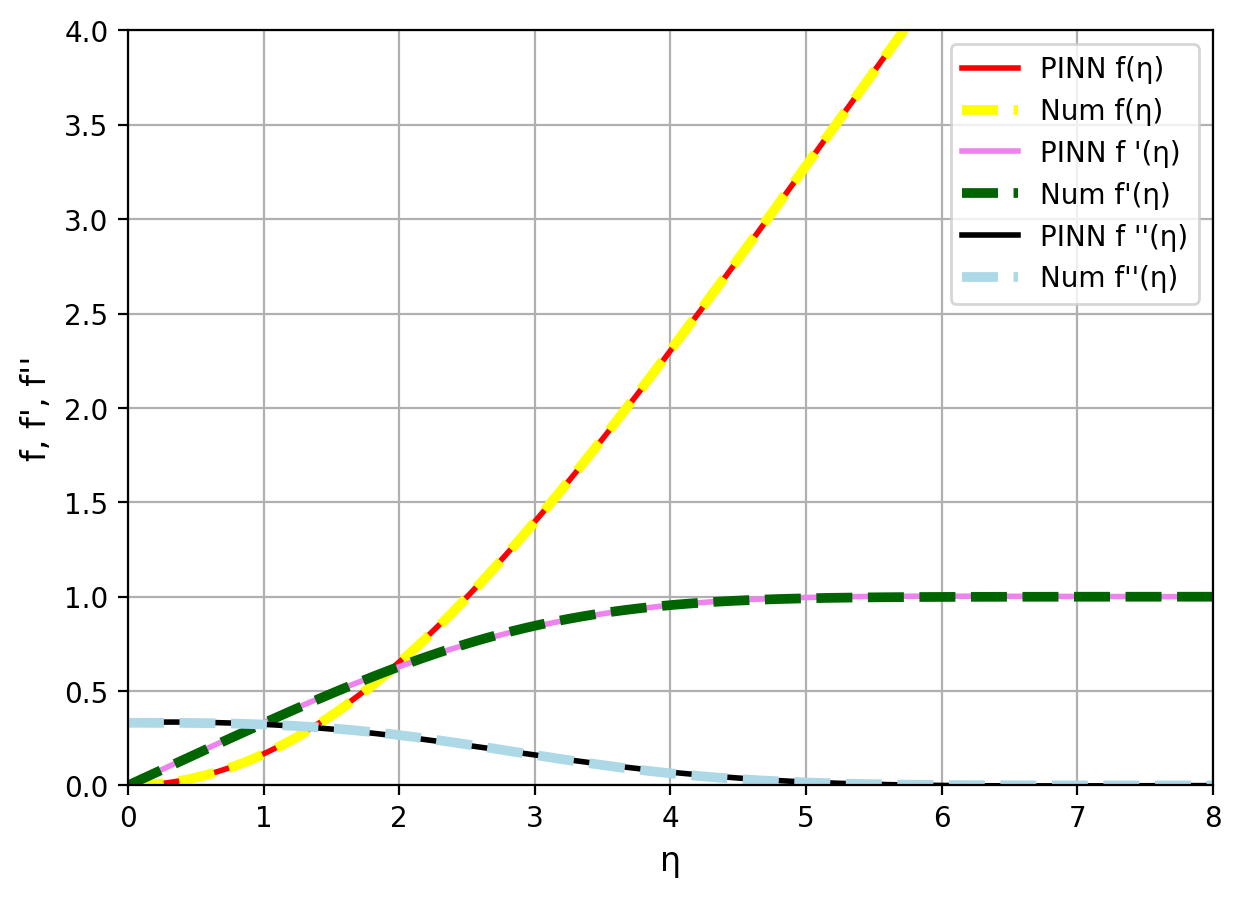

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5),dpi=200)
plt.plot(X_star,u_pred,label="PINN f(η)",color="red",linewidth=2)
plt.plot(X_star,u_star,linestyle="dashed",label="Num f(η)",linewidth=3.5,color="yellow")
plt.plot(X_star,u_x,label="PINN f '(η)",linewidth=2,color="violet")
plt.plot(X_star,fir_der,linestyle="dashed",label="Num f'(η)",linewidth=3.5,color="darkgreen")
plt.plot(X_star,u_xx,label="PINN f ''(η)",color="black",linewidth=2)
plt.plot(X_star,second_der,linestyle="dashed",label="Num f''(η)",linewidth=3.5,color="lightblue")

plt.ylabel("f, f', f''",fontsize=12)
plt.xlabel(chr(951),fontsize=12)
plt.xlim(0,8)
plt.ylim(0,4)
#plt.title("lr=1 , Loss=3.532921e-04 \n Layers=[100,100,100] η=(0,30) ")
plt.legend()
plt.grid()
plt.savefig("Final.png")


In [ ]:
l18=[]
for i in u_pred:
    l18.append(i[0])
print(l18)

[2.7656555e-05, 3.0994415e-05, 3.0994415e-05, 3.6239624e-05, 4.2915344e-05, 6.532669e-05, 8.535385e-05, 0.00010347366, 0.0001282692, 0.00015878677, 0.00017976761, 0.00021743774, 0.00024700165, 0.00028896332, 0.00031805038, 0.00036287308, 0.00042057037, 0.00046300888, 0.0005078316, 0.0005712509, 0.0006289482, 0.0006904602, 0.00076007843, 0.0008292198, 0.0008916855, 0.00097084045, 0.001060009, 0.0011315346, 0.001209259, 0.0012979507, 0.0013828278, 0.001475811, 0.00157547, 0.0016674995, 0.0017662048, 0.0018634796, 0.0019755363, 0.0020923615, 0.0021996498, 0.002318859, 0.002439499, 0.0025568008, 0.0026845932, 0.0028095245, 0.0029468536, 0.003080368, 0.0032176971, 0.003358364, 0.0035009384, 0.0036387444, 0.0037961006, 0.003944874, 0.004102707, 0.004255295, 0.004419327, 0.00458622, 0.004755497, 0.0049214363, 0.005095482, 0.0052723885, 0.00544405, 0.0056390762, 0.0058169365, 0.006011009, 0.006205559, 0.00639534, 0.006588936, 0.00679636, 0.0069909096, 0.0072083473, 0.007411957, 0.007625103, 0.

In [ ]:
#np.random.seed(708)
import random
random.seed(1234)
print(random.random())

1 #  
lr=1 (200)  #  
f''(0)=0.332092  #   
error= 3.615032e-04   #    
90,90,90  # 
90train
##############  
2 #  
lr=1   #
f''(0)=0.333862  #  
error= 4.215800e-04  #  
95,95,95  #  
90train
###############   
3 #  
lr=1   #   
f''(0)= 0.332692  #  
error=2.179575e-04  #   
100,100,100   #  
90train
#############  
4 #  
lr=1 (708)  #   
f''(0)= 0.358558  #  
error=2.860886e-02  #   
100,100,100   #  
80 train
#############  
5 #  
lr=1 (708)  #   
f''(0)= 0.328709 #  
Error u: 4.121953e-04 #  
80,80,80,80   #  
90 train
############# 
############# 